<a href="https://colab.research.google.com/github/SeiichiroFukushima/keras/blob/master/Train_KerasRNN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **時系列予測** 

このトライはチュートリアル[TensorFlowの時系列予測]を参考にして、TensorFlow を使用した溶接電源からの特徴量及びカメラ画像解析で得られたスパッタ発生量の時系列データからスパッタ発生量を予測するトライを行います。回帰ニューラルネットワーク（RNN）のモデルを構築して推論をトライします。

※ここでは、サブセクションを伴う 2 つの主なパートが説明されています。

単一の時間ステップの予測
単一の特徴量。
すべての特徴量。
複数のステップの予測
シングルショット: すべての予測を一度に行います。
自動回帰: 一度に 1 つの予測を行い、出力をモデルにフィードし直します。

セットアップ

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## **溶接電源特徴量ｘスパッタ発生量 データセット**
このサンプルテスト室で取得した溶接電源からの特徴量とカメラ画像解析で求められたスパッタ発生量の時系列データセットを使用します。

このデータセットには、Fb電流、Fb電圧、微小短絡時間といった 24 個特徴量とスパッタ発生量が含まれます。これらは、500usごとに収集されたデータです。ゼロ値が多いので有意な変化が現れるようにするために、取り敢えず10ms毎の時系列データにダウンサンプリングを行います。

## データのロード

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from pandas import Series, DataFrame
import pandas as pd

# データの読み込み
#data = pd.read_csv('testAVspatter.csv')
#data = pd.read_csv('testAVspatter2_45.csv') #実験の最初２秒間と最後の１秒を除外
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test20230508_ALL_2_45.csv') #実験の最初２秒間と最後の１秒を除外(２４次元)


In [4]:
# フレームデータをdatetimeオブジェクトに変換する
date_time  = pd.to_datetime(df.pop('Time'), unit='s')


データをのぞいてみましょう。最初の数行は、次のようになっています。

In [5]:
df.head()

,CurrFB,VoltFB,ArcLost,Shrt_T,ArcT,Shrt_N,Plus_N,Necking_T,NeckingMiss_N,ArcPeak_V,...,AbnrmlShrtOpn_N,Shrt_InPeak_N,PlsBase_Brn_N,CurrCmpns_kpT,CurrCmpns_1time,CorrV_1time,CorrT_1time,CorrWFS_1time,reserve,spatter
0,168,322,0,0,26,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,165,323,0,0,26,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,168,315,0,0,26,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,165,316,0,0,26,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,162,314,0,0,26,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9


時が経過するにつれ、いくつかの特徴量は次のように変化しています。

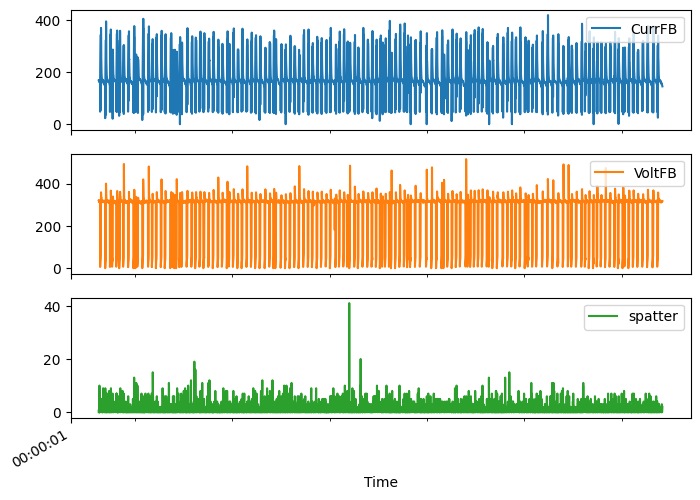

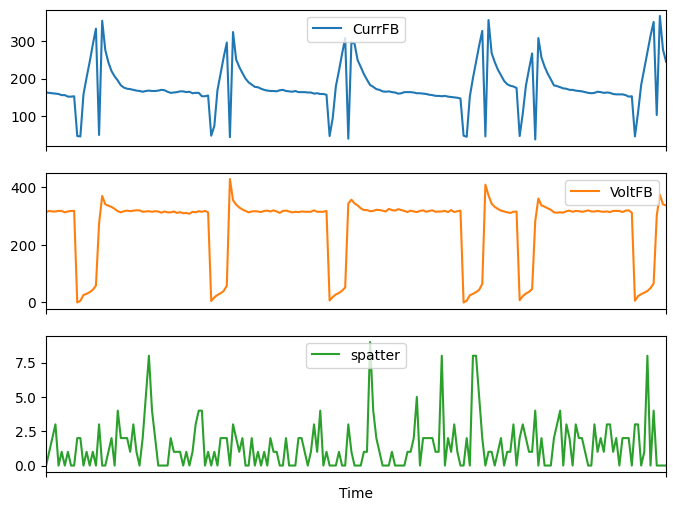

In [6]:
plot_cols = ['CurrFB', 'VoltFB', 'spatter']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

target_time = pd.to_datetime('1970-01-01 00:00:02.500500')
nearest_indexA = np.abs(date_time-target_time).argmin()
target_time = pd.to_datetime('1970-01-01 00:00:02.600500')
nearest_indexB = np.abs(date_time-target_time).argmin()

plot_features = df[plot_cols].iloc[nearest_indexA:nearest_indexB]
plot_features.index = date_time.iloc[nearest_indexA:nearest_indexB]
_ = plot_features.plot(subplots=True)


## 検査とクリーンアップ

検査とクリーンアップ
次に、データセットの統計を確認してみましょう。

In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CurrFB,5001.0,177.935813,57.902232,0.0,159.0,167.0,187.0,418.0
VoltFB,5001.0,268.918216,111.399895,0.0,312.0,316.0,319.0,516.0
ArcLost,5001.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
Shrt_T,5001.0,4.846831,11.278481,0.0,0.0,0.0,0.0,60.0
ArcT,5001.0,21.152569,9.811183,0.0,26.0,26.0,26.0,26.0
Shrt_N,5001.0,0.026995,0.162084,0.0,0.0,0.0,0.0,1.0
Plus_N,5001.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
Necking_T,5001.0,0.412318,2.198991,0.0,0.0,0.0,0.0,20.0
NeckingMiss_N,5001.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
ArcPeak_V,5001.0,10.085583,60.861336,0.0,0.0,0.0,0.0,525.0


高速フーリエ変換で特徴量を抽出し、どの周波数が重要であるかを判断することができます。予想を確認するために、以下に、時間の経過に伴う時系列データの内溶接電圧の tf.signal.rfft を示します。

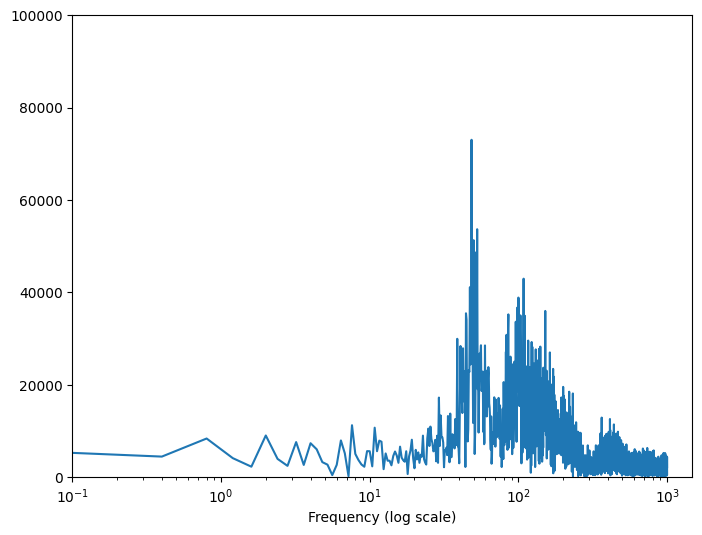

In [8]:
fft = tf.signal.rfft((df['VoltFB']))

#サンプルの数
n_samples = len(df['VoltFB'])
#得られた時系列データのサンプル時間: 5sec
sample_T = 5.0
#サンプリング周波数: 1/500us
sampling_freq = 1/0.0005
# 周波数軸のデータ作成
fq = np.linspace(0, sampling_freq, n_samples) # 周波数軸　linspace(開始,終了,分割数)

plt.plot(fq[:int(n_samples/2)+1], np.abs(fft)[:int(n_samples/2)+1])
plt.xscale('log')
plt.ylim(0, 100000)
plt.xlim([0.1, max(plt.xlim())])
#plt.xticks([1, int(n_samples/2)+1], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

Fb電圧波形には50Hz（20ms）と150Hz（6ms）あたりにピークがありそう。

同様にFb電流波形や、スパッタ発生量についてもフーリエ変換してみる。

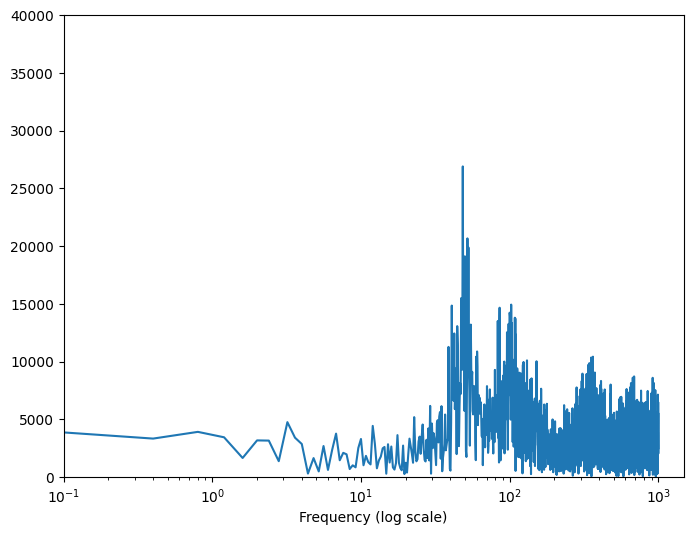

In [9]:
fft = tf.signal.rfft((df['CurrFB']))

#サンプルの数
n_samples = len(df['CurrFB'])
#得られた時系列データのサンプル時間: 5sec
sample_T = 5.0
#サンプリング周波数: 1/500us
sampling_freq = 1/0.0005
# 周波数軸のデータ作成
fq = np.linspace(0, sampling_freq, n_samples) # 周波数軸　linspace(開始,終了,分割数)

plt.plot(fq[:int(n_samples/2)+1], np.abs(fft)[:int(n_samples/2)+1])
plt.xscale('log')
plt.ylim(0, 40000)
plt.xlim([0.1, max(plt.xlim())])
#plt.xticks([1, int(n_samples/2)+1], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

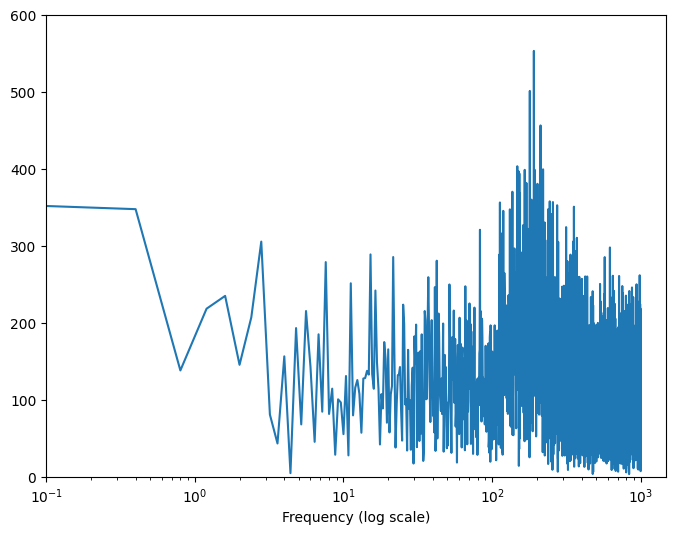

In [10]:
fft = tf.signal.rfft((df['spatter']))

#サンプルの数
n_samples = len(df['spatter'])
#得られた時系列データのサンプル時間: 5sec
sample_T = 5.0
#サンプリング周波数: 1/500us
sampling_freq = 1/0.0005
# 周波数軸のデータ作成
fq = np.linspace(0, sampling_freq, n_samples) # 周波数軸　linspace(開始,終了,分割数)

plt.plot(fq[:int(n_samples/2)+1], np.abs(fft)[:int(n_samples/2)+1])
plt.xscale('log')
plt.ylim(0, 600)
plt.xlim([0.1, max(plt.xlim())])
#plt.xticks([1, int(n_samples/2)+1], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

電流、電圧波形は似たような周波数にピークを持っているが、スパッタ発生量は異なっており
200Hz(5ms)辺りにピークがある。
これは、実験でカメラで計測するようなスパッタの発生は、溶接の特徴的な周期で発生している短絡で起こるのではなく、別の意図しないタイミングで発生するということなのか？

## データの分割

トレーニング、検証、およびテスト用のセットとして、(70%, 20%, 10%) に分割したものを使用します。データの分割前に、ランダムにシャッフルされていないことに注意してください。これには、次の 2 つの理由があります。

    1.連続したサンプルの期間にデータが分割されていることを確実にするため。
    2.検証/テストの結果がより現実的で、モデルがトレーニングされた後に収集されたデータを評価できるようにするため。

In [11]:
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [12]:
print('Original data [df] size=',n, ', df.shape:',df.shape, )
print('train size:', len(train_df), 'val size:', len(val_df), 'test size:', len(test_df))

Original data [df] size= 5001 , df.shape: (5001, 25)
train size: 3500 val size: 1000 test size: 501


## データの正規化

ニューラルネットワークをトレーニングする前に特徴量をスケーリングすることが重要です。正規化は、このスケーリングを行うための一般的な方法です。平均を減算して各特徴量の標準偏差で除算します。

平均と標準偏差は、モデルが検証とテストのセットにある値にアクセスできないように、トレーニングデータを使用してのみ計算する必要があります。

また、モデルがトレーニング中にトレーニングセットの未来の値にアクセスしないことと、この正規化が、移動する平均を使用して行われるようにすることにも論拠があります。このことは、このチュートリアルの焦点ではなく、検証とテストのセットによって、（ある程度）正直なメトリックが得られるようになっています。そのため、単純化するために、このチュートリアルでは、単純な平均を使用しています。

In [13]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

では、特徴量の分布をみてみましょう。

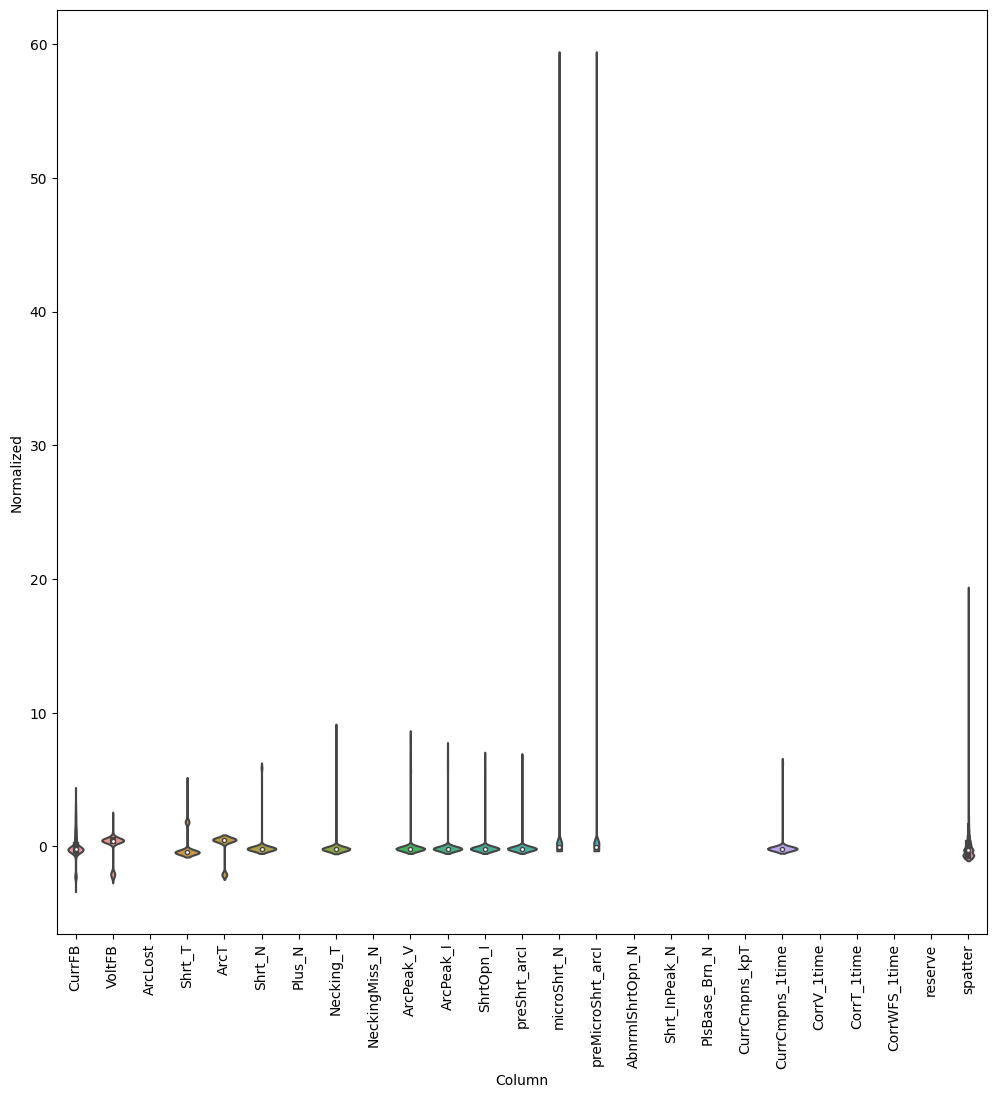

In [14]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 12))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## データのウィンドウ処理

このチュートリアルのモデルは、データの連続するサンプルのウィンドウに基づいてあるセットの予測を立てます。

入力ウィンドウの主な特徴量は次の通りです。

入力とラベルウィンドウの幅（時間ステップ数）
それらの時間オフセット
どの特徴量が入力かラベル、またはこの両方として使用されているか
このチュートリアルは、様々なモデル（線形、DNN、CNN、および RNN モデル）を構築し、次の両方に対して使用します。

単一出力および複数出力予測。
単一時間ステップと複数時間ステップ予測。
このセクションでは、こういったすべてのモデルに再利用できるようにデータウィンドウ処理を実装することに焦点を当てています。

モデルのタスクと種類に応じて、様々なデータウィンドウを生成するようにするとよいでしょう。次にいくつかのサンプルを示します。

たとえば、0.0025秒先の単一予測を立てるには、過去 0.0025秒間の履歴を指定し、次のようにウィンドウを定義することができます。
![One prediction 24 hours into the future.](images/raw_window_2500us.png)

また、0.0005sec先の予測を立てるモデルは、過去0.003secの履歴を指定した場合、次のようにウィンドウを定義する必要があります。
  ![One prediction one hour into the future.](images/raw_window_500us.png)
  
このセクションの残りの部分では、WindowGenerator クラスを定義します。このクラスは、次の項目を行えます。

インデックスとオフセットを、上記の図に示されるように処理する。
特徴量のウィンドウを (features, labels) ペアに分割する。
結果のウィンドウのコンテンツを描画する。
トレーニング、評価、およびテストデータからのこれらのウィンドウのバッチを、tf.data.Dataset を使用して効率的に生成する。

### 1. インデックスとオフセット

WindowGenerator クラスの作成から始めます。__init__ メソッドには、入力とラベルインデックスに必要なすべての論理が含まれます。

また、トレーニング、評価、およびテストの DataFrames を入力として取ります。これらは、後でウィンドウの tf.data.Dataset に変換されます。

In [15]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

次は、このセクションの始めの図に示された 2 つのウィンドウを作成するコードです。

In [16]:
#input_widthやlabel_widthの値は、時間で溶接テストで取得された時系列データの単位の秒

#w1 = WindowGenerator(input_width=0.5, label_width=0.1, shift=0.5,
#                     label_columns=['CurrFB'])

#スライスのインデックスが整数でなければならない。
#self.input_sliceが整数ではないためにエラーが発する。

#1sec 1sec 1secにしてみる
#target_time = pd.to_datetime('1970-01-01 00:00:02.500000')
#nearest_indexA = np.abs(date_time-target_time).argmin()
#target_time = pd.to_datetime('1970-01-01 00:00:03.000000')
#nearest_indexB = np.abs(date_time-target_time).argmin()
#dN = nearest_indexB - nearest_indexA
#w1 = WindowGenerator(input_width=dN, label_width=int(dN/5), shift=dN, label_columns=['CurrFB'])
w1 = WindowGenerator(input_width=6, label_width=1, shift=6, label_columns=['CurrFB'])

w1

Total window size: 12
Input indices: [0 1 2 3 4 5]
Label indices: [11]
Label column name(s): ['CurrFB']

In [17]:
#w2 = WindowGenerator(input_width=dN, label_width=int(dN/5), shift=int(dN/5),
#                     label_columns=['CurrFB'])
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['CurrFB'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['CurrFB']

### 2. 分割

リストの連続入力がある場合、split_window メソッドはこれらを入力のウィンドウとラベルのウィンドウに変換します。

前に定義した例の w2 は次のように分割されます。

![The initial window is all consecutive samples, this splits it into an (inputs, labels) pairs](images/split_window_us.png)

この図は、データの features 軸を表示しませんが、この split_window 関数は、label_columns も処理するため、単一出力と複数出力の例の両方に使用できます。

In [18]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

次を試します。

In [19]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 25)
Inputs shape: (3, 6, 25)
Labels shape: (3, 1, 1)


通常 TensorFlow のデータは、最も外側のインデックスがサンプル全体である配列にパックされます（「batch」次元）。中央のインデックスは、「time」または「space」（width, height）次元です。最も内側のインデックスは特徴量です。

上記のコードは、バッチ 3、7 時間ステップウィンドウ、各時間ステップに 19 個の特徴量を取りました。これを 6 時間ステップ、19 個の特徴量入力、および 1 時間ステップ 1 特徴量ラベルに分割しました。ラベルには、WindowGenerator が label_columns=['CurrFB'] で初期化されたため、1 つの特徴量しかありません。最初に、このチュートリアルは単一出力ラベルを予測するモデルを構築します。

### 3. 描画 

次は、分割ウィンドウを単純に視覚化できる描画（plot）メソッドです。

In [20]:
w2.example = example_inputs, example_labels

In [21]:
def plot(self, model=None, plot_col='CurrFB', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [sec]')

WindowGenerator.plot = plot

この図は、入力、ラベル、および（後の）予測を、項目が参照する時間に基づいて整列します。

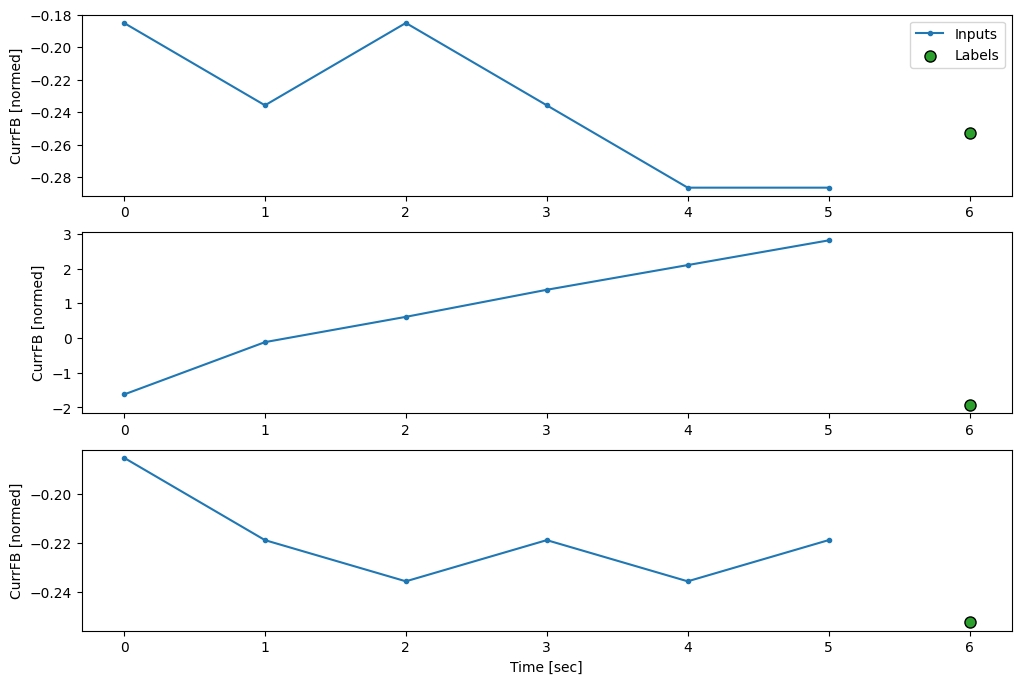

In [22]:
w2.plot()

ほかの列を描画することはできますが、サンプルウィンドウ w2 構成には、CuttFB 列のラベルしかありません。

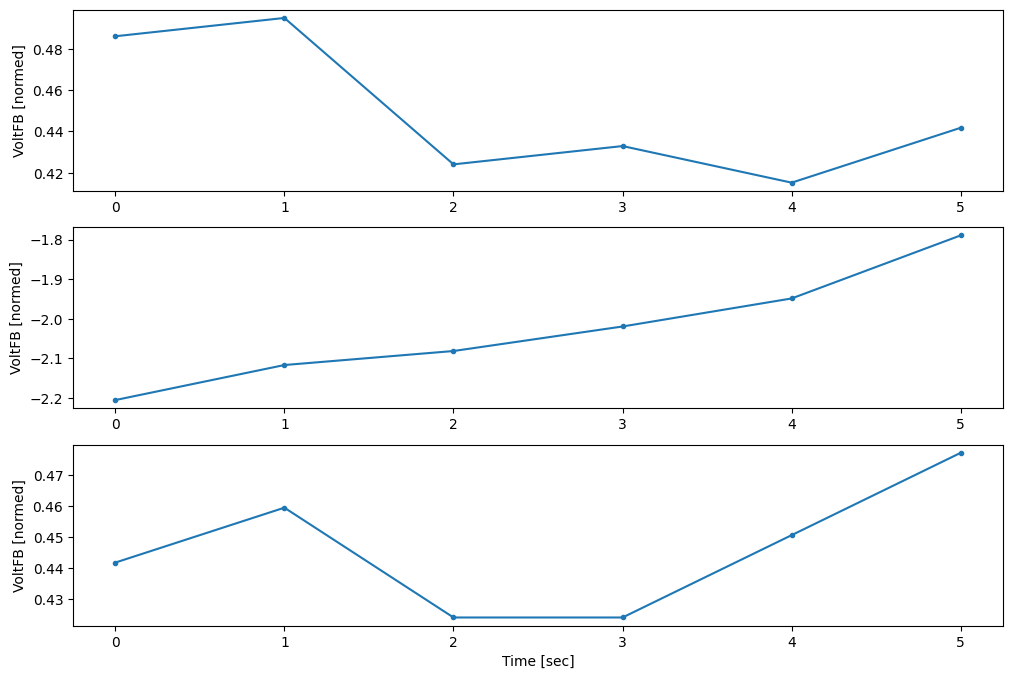

In [23]:
w2.plot(plot_col='VoltFB')

### 4. tf.data.Dataset の作成 

最後に、この make_dataset メソッドは時系列 DataFrame を取って、tf.keras.utils.timeseries_dataset_from_array 関数を使用して (input_window, label_window) ペアの tf.data.Dataset に変換します。

In [24]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

WindowGenerator オブジェクトには、トレーニング、検証、およびテストのデータが含まれます。

これらにアクセスするためのプロパティを tf.data.Dataset として追加し、前に定義したmake_dataset メソッドを使用します。また、標準のサンプルバッチを追加して、簡単にアクセスして描画できるようにします。

In [25]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

WindowGenerator オブジェクトにより、tf.data.Dataset オブジェクトにアクセスできるようになったため、データを簡単にイテレートできるようになりました。

Dataset.element_spec プロパティは、データセット要素の構造、データ型、および形状を示します。

In [26]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 25), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

Dataset をイテレートすると、具象バッチを得られます。

In [27]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 25)
Labels shape (batch, time, features): (32, 1, 1)


# 単一ステップモデル
このようなデータで構築できる最も単純なモデルは、現在の条件のみに基づいて、1 時間ステップ（1 時間）先までの単一の特徴量の値を予測するモデルです。

そのため、1 時間先までの T (degC) 値を予測するモデルを構築することにします。

Predict the next time step

WindowGenerator オブジェクトを構成して、これらの単一ステップ (input, label) ペアを生成します。

In [28]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['CurrFB'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['CurrFB']

window オブジェクトは、トレーニング、検証、およびテストのセットから tf.data.Datasets 作成し、データのバッチを簡単にイテレートできるようにします。

In [29]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 25)
Labels shape (batch, time, features): (32, 1, 1)


# 基準
トレーニング可能なモデルを構築する前に、後のより複雑なモデルと比較するための基準ポイントとして、パフォーマンス基準を設定します。

最初のタスクは、すべての特徴量の現在の値がある場合に、1 時間先までの気温を予測することです。現在の値には、現在の気温が含まれます。

では、現在の気温のみを予測として返し、「変化なし」と予測するモデルから始めましょう。気温はゆっくりと変化するため、これは合理的な基準と言えます。もちろん、予測をずっと先まで行う場合は、この基準はあまり機能しなくなります。

Send the input to the output

In [30]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

このモデルをインスタンス化して評価します。

In [31]:
#baseline = Baseline(label_index=column_indices['CurrFB'])
baseline = Baseline(label_index=0)

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

32/32 [==============================] - 0s 4ms/step - loss: 1.2434 - mean_absolute_error: 0.4796


これによって何らかのパフォーマンスメトリックが出力されましたが、このモデルがどれくらいうまく機能しているかに対する感触は得られません。

WindowGenerator には描画メソッドがありますが、サンプルが 1 つしかないのであれば、興味深い描画にはなりません。

そこで、24 時間連続入力とラベルのウィンドウを一度に生成するより幅の広い WindowGenerator を作成することにします。新しい wide_window 変数によってモデルの動作が変わることはありません。モデルは引き続き、1 つの入力時間ステップに基づいて 1 時間先の予測を立てます。ここでは、time 軸は batch 軸として機能します。各予測は、時間ステップ間で相互作用のない独立した予測となります。

In [32]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['CurrFB'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['CurrFB']

コードを変更することなく、上記の拡張されたウィンドウを同じ baseline モデルに直接渡すことができます。これは、入力とラベルに同じ数の時間ステップがあり、基準は入力を出力に転送するだけであるため、可能です。

In [33]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 25)
Output shape: (32, 24, 1)


基準モデルの予測を描画すると、ラベルが 1 時間右に移動しただけであることがわかります。

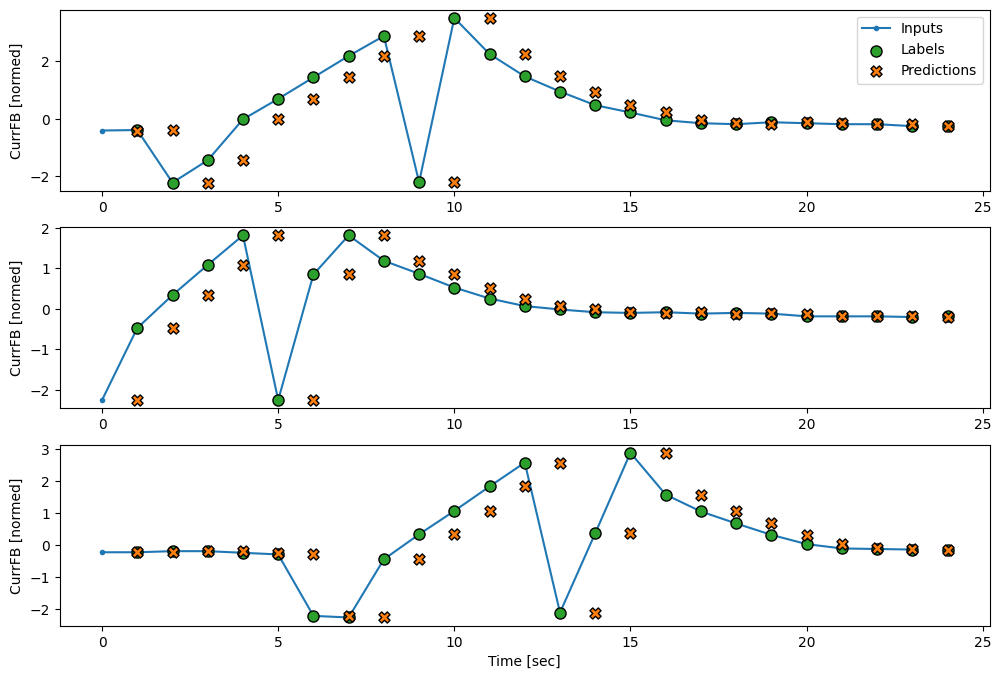

In [34]:
wide_window.plot(baseline)

上記の 3 つの例の図には、単一ステップモデルが 24 時間分実行されています。これには、次のような理由があります。

青い Inputs の線は、各時間ステップの入力気温を示します。モデルはすべての特徴量を受け取りますが、この図は気温のみを示します。
緑色の Labels の点は、ターゲットの予測値を示します。これらの点は入力時間ではなく、予測時間に示されます。そのため、ラベルの範囲は入力に対して 1 ステップ移動しています。
オレンジ色の Predictions の十字は、各出力時間ステップのモデルの予測です。モデルが完璧に予測しているのであれば、予測は Labels に着地します。

# 線形モデル
このタスクに適用できる最も単純なトレーニング可能なモデルは、入力と出力間に線形変換を挿入することです。この場合、ある時間ステップの出力は、そのステップのみに依存します。

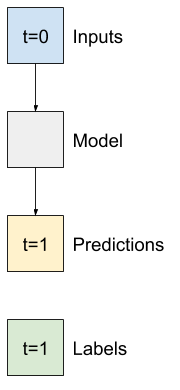

activation セットのない tf.keras.layers.Dense レイヤーは線形モデルです。レイヤーはデータの最後の軸のみを (batch, time, inputs) から (batch, time, units) に変換するため、batch と time 軸の各項目に独立して適用されます。

In [35]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [36]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 25)
Output shape: (32, 1, 1)


このチュートリアルは、多くのモデルをトレーニングするため、トレーニング手順を関数にパッケージ化します。

In [37]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

モデルをトレーニングしてそのパフォーマンスを評価します。

In [38]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
110/110 [==============================] - 1s 6ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 2/20
32/32 [==============================] - 0s 4ms/step - loss: nan - mean_absolute_error: nan


baseline モデルと同様に、線形モデルは、ワイドウィンドウのバッチで呼び出すことができます。このように使用することで、モデルは連続した時間ステップに対して独立した一連の予測を立てます。time 軸は、別の batch 軸のように機能します。各時間ステップの予測間に相互作用はありません。

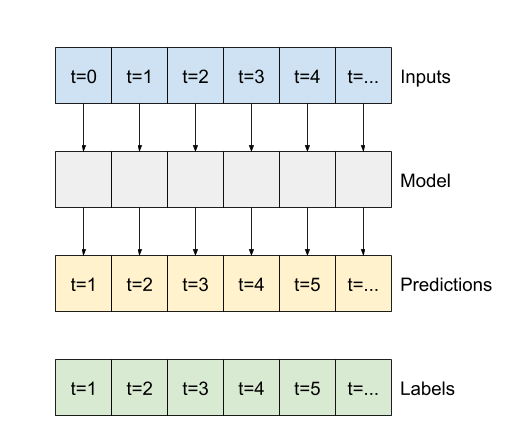

In [39]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 25)
Output shape: (32, 24, 1)


次は、wide_widow に対するサンプル予測の図です。多くの場合、入力気温のみを返すよりも予測が明らかに優れているのがわかりますが、いくつかのケースでは悪化しています。

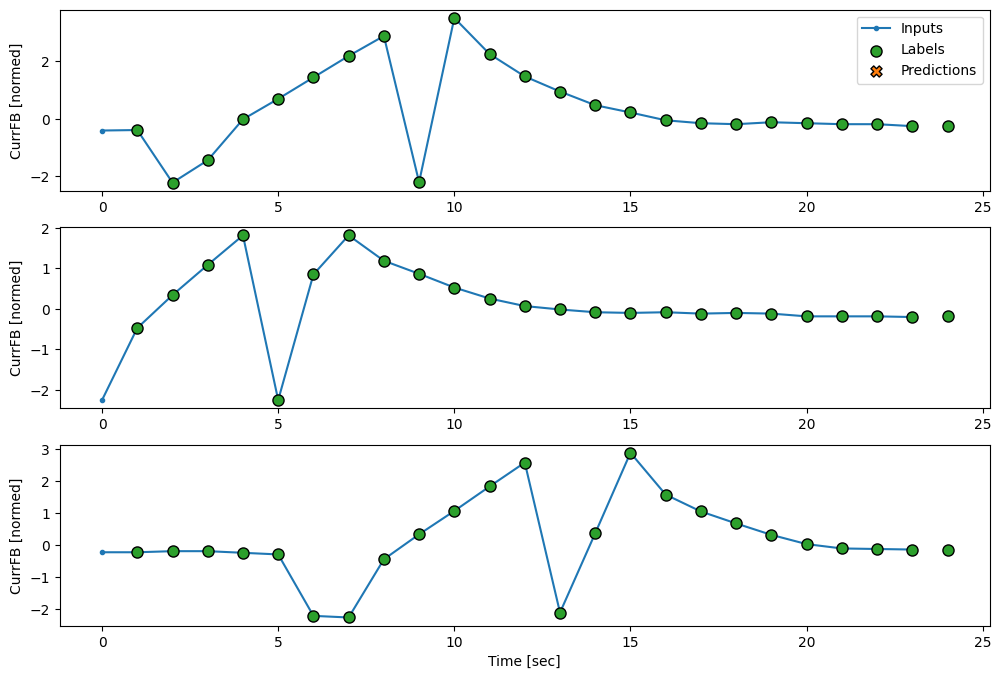

In [40]:
wide_window.plot(linear)

線形モデルには、比較的解釈しやすいというメリットがあります。レイヤーの重みを引き出して、各入力に割り当てられた重みを確認することができます。

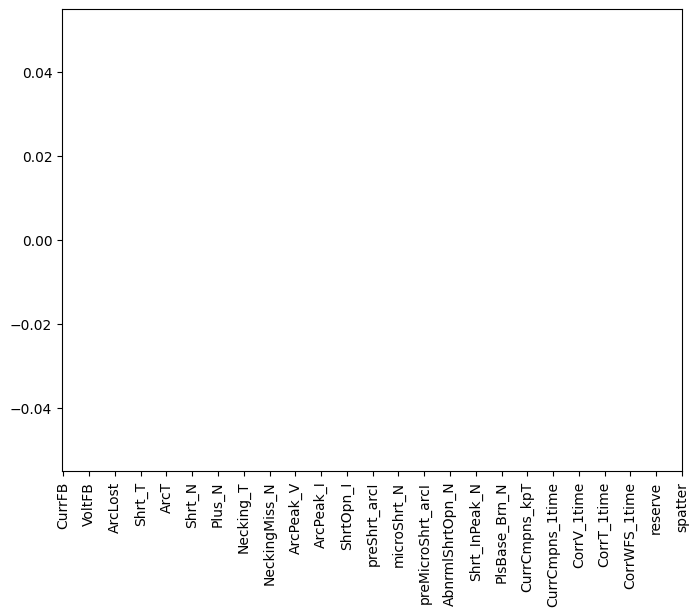

In [41]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

場合によっては、モデルには、入力 T (degC) のほとんどの重みを配置しないこともあります。これが、ランダム初期化のリスクの 1 つです。

#密度
複数の時間ステップで実際に動作するモデルを適用する前に、より深く強力な単一入力ステップモデルのパフォーマンスを確認しておく価値があります。

次は、linear モデルに似たモデルですが、入力と出力の間にいくつかの Dense でイヤーがスタックされています。

In [42]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
110/110 [==============================] - 2s 9ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 2/20
32/32 [==============================] - 0s 4ms/step - loss: nan - mean_absolute_error: nan


#複数ステップの密度
単一時間ステップモデルには、入力の現在の値に関するコンテキストがありません。そのため、時間の経過とともに、入力特徴量が変化する様子を確認できません。この問題を解決するために、モデルは予測を立てる際に複数の時間ステップにアクセスする必要があります。

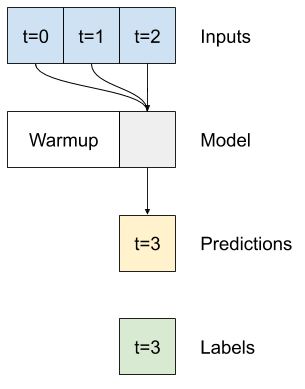

baseline、linear、および dense モデルは、各時間ステップを個別に処理しました。ここでは、モデルは複数の時間ステップを入力として取り、単一の出力を生成します。

3 時間分の入力のバッチと、1 時間のラベルを生成する WindowGenerator を作成します。

Window の shift パラメータが 2 つのウィンドウの最後に相対的であるところに注意してください。

In [43]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['CurrFB'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['CurrFB']

Text(0.5, 1.0, 'Given 3 hours of inputs, predict 1 hour into the future.')

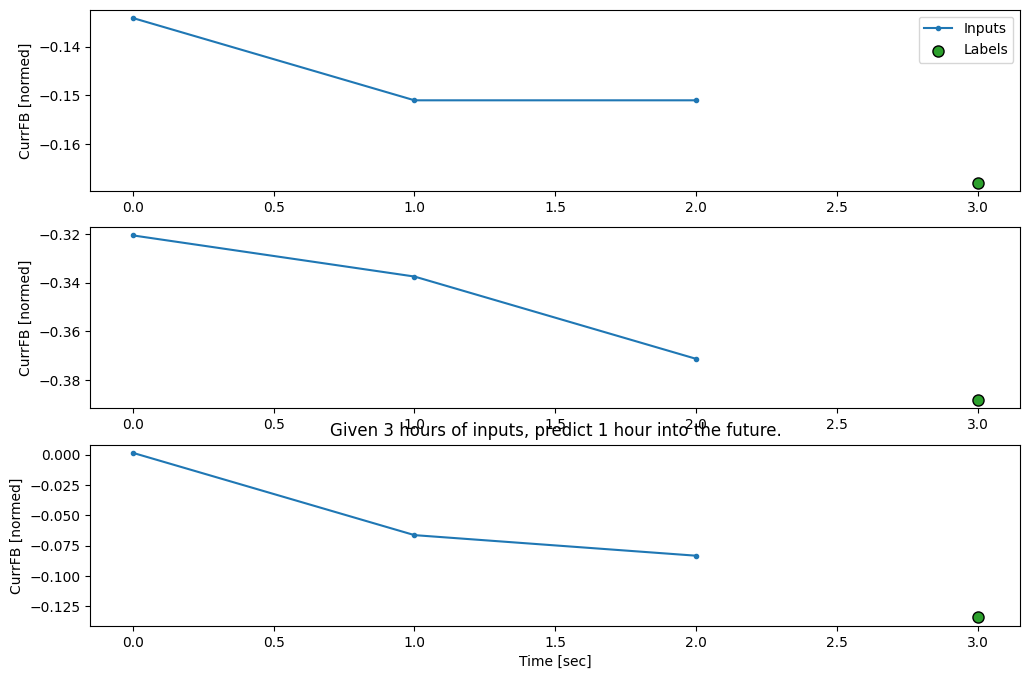

In [44]:
conv_window.plot()
plt.title("Given 3 hours of inputs, predict 1 hour into the future.")

モデルの最初のレイヤーとして tf.keras.layers.Flatten を追加することで、複数入力ステップウィンドウで dense モデルをトレーニングすることができます。

In [45]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [46]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 25)
Output shape: (32, 1, 1)


In [47]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

32/32 [==============================] - 0s 3ms/step - loss: nan - mean_absolute_error: nan


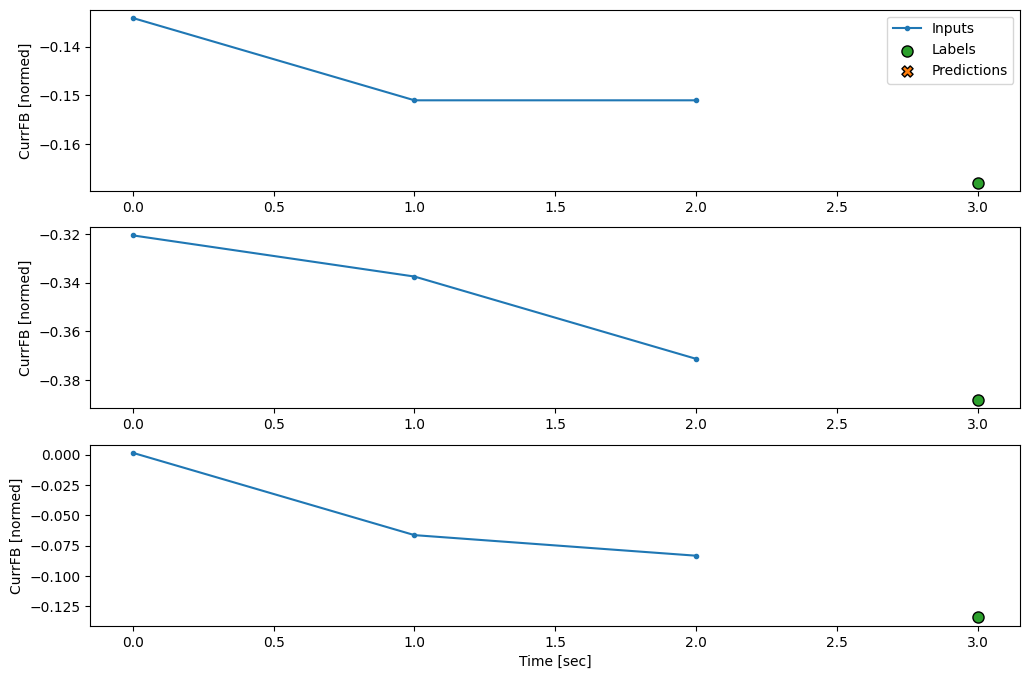

In [48]:
conv_window.plot(multi_step_dense)

このアプローチの主な欠点は、結果モデルを、まったくこの形状の入力ウィンドウでしか実行できないことです。

In [49]:
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 24, 25)

ValueError:Exception encountered when calling layer 'sequential_2' (type Sequential).

Input 0 of layer "dense_4" is incompatible with the layer: expected axis -1 of input shape to have value 75, but received input with shape (32, 600)

Call arguments received by layer 'sequential_2' (type Sequential):
  • inputs=tf.Tensor(shape=(32, 24, 25), dtype=float32)
  • training=None
  • mask=None


この問題は、次のセクションの畳み込みモデルで解決することができます。

# 畳み込みニューラルネットワーク
畳み込みレイヤー（tf.keras.layers.Conv1D）も、複数の時間ステップを各予測への入力として取ります。

以下に示すのは、multi_step_dense と同じモデルを畳み込みで書き直したものです。

次の変更箇所に注意してください。

tf.keras.layers.Flatten と最初の tf.keras.layers.Dense は tf.keras.layers.Conv1D に置き換えられています。
畳み込みが出力に time 軸を維持するため、tf.keras.layers.Reshap は不要となっています。

In [50]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

これをサンプルバッチで実行し、モデルが期待される形状の出力を生成することを確認します。

In [51]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 25)
Output shape: (32, 1, 1)


conv_window でトレーニングして評価すると、multi_step_dense モデルと似たようなパフォーマンスが得られます。

In [52]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

32/32 [==============================] - 0s 3ms/step - loss: nan - mean_absolute_error: nan


この conv_model と multi_step_dense モデルの違いは、conv_model はあらゆる長さの入力に対して実行できるところにあります。畳み込みレイヤーは入力のスライドウィンドウに適用されます。

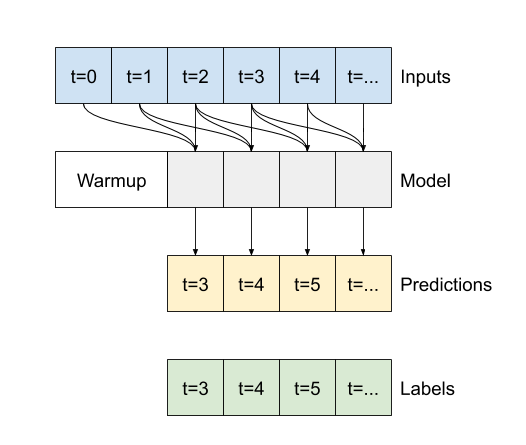

より幅広い入力に対してこれを実行する場合、生成される出力も幅広くなります。

In [53]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 25)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


出力が入力よりも短いことに注意してください。トレーニングまたは描画がうまく機能するには、ラベルと、長さの同じ予測が必要です。そのため、いくつかの入力時間ステップを追加してワイドウィンドウを生成し、ラベルと予測の長さが一致するように、WindowGenerator を構築します。

In [54]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['CurrFB'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['CurrFB']

In [55]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 25)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


これで、幅広いウィンドウでモデルの予測を描画できるようになりました。最初の予測の前に、3 つの入力時間ステップがあることに注目してください。各予測は、前の 3 つの時間ステップに基づきます。

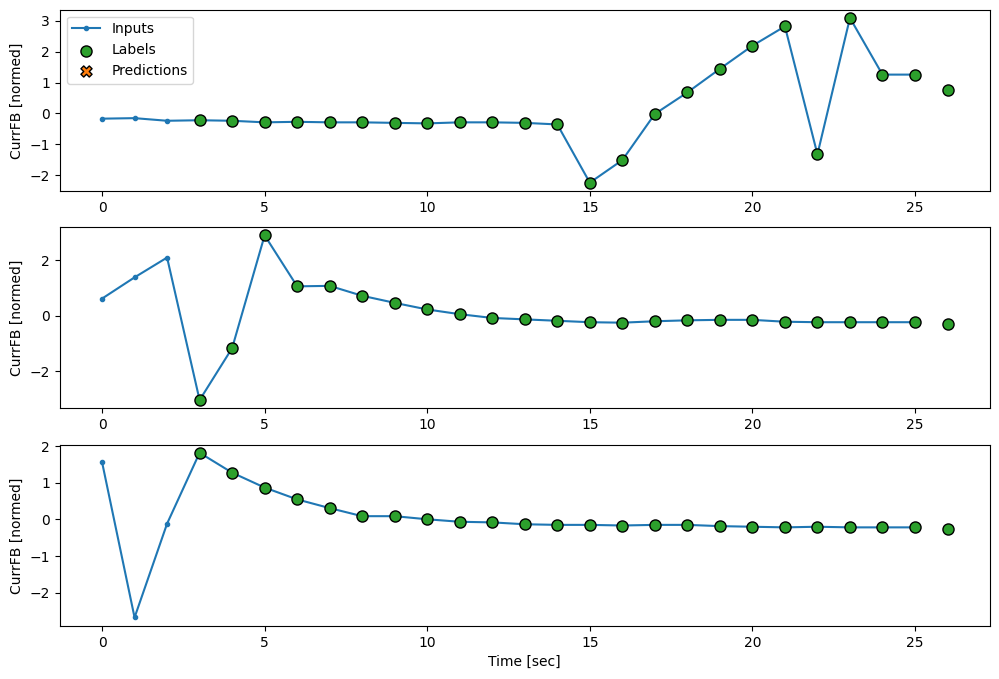

In [56]:
wide_conv_window.plot(conv_model)

# 回帰ニューラルネットワーク
回帰ニューラルネットワーク（RNN）は、時系列データに最適なニューラルネットワークの種類です。RNN は、ステップごとに時系列を処理し、時間ステップから時間ステップまでの内部状態を維持することができます。

RNN によるテキスト生成チュートリアルと Keras による回帰ニューラルネットワーク（RNN）ガイドでさらに学習することができます。

このチュートリアルでは、Long Short Term Memory（tf.keras.layers.LSTM）という RNN レイヤーを使用します。

tf.keras.layers.LSTM などのすべての Keras RNN レイヤーの重要なコンストラクタ引数は、return_sequences 引数です。この設定は、次の 2 つのいずれかの方法でレイヤーを構成することができます。



1.  False である場合（デフォルト）、レイヤーは、最後の時間ステップの出力のみを返すため、単一の予測を立てる前に、内部状態をウォームアップする時間を得られます。

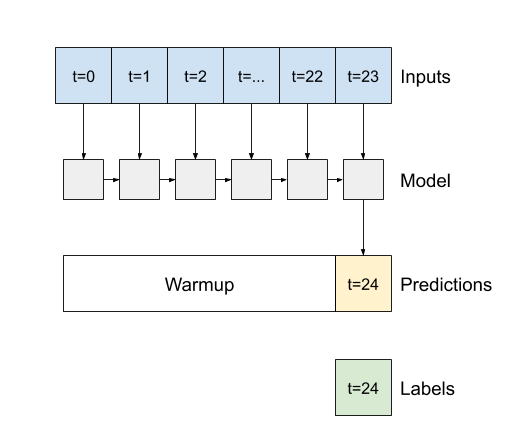

2.   項目True である場合、レイヤーは、各入力に対する出力を返し、次の項目に役立てることができます。


*   RNN レイヤーのスタック。
*   複数の時間ステップで同時にモデルをトレーニングする。

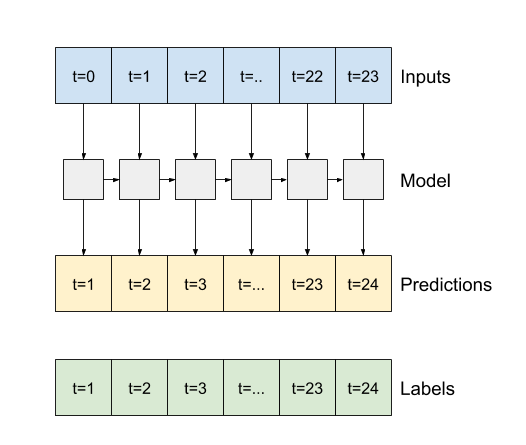






In [57]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

return_sequences=True の場合、24 時間のデータで一度にモデルをトレーニングすることができます。

注意: モデルのパフォーマンスとしては悲観的な見解になります。最初の時間ステップは前のステップにアクセスできないため、上記に示した単純な linear モデルと dense モデルとあまり変わりません。

In [58]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 25)
Output shape: (32, 24, 1)


In [59]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

31/31 [==============================] - 0s 6ms/step - loss: nan - mean_absolute_error: nan


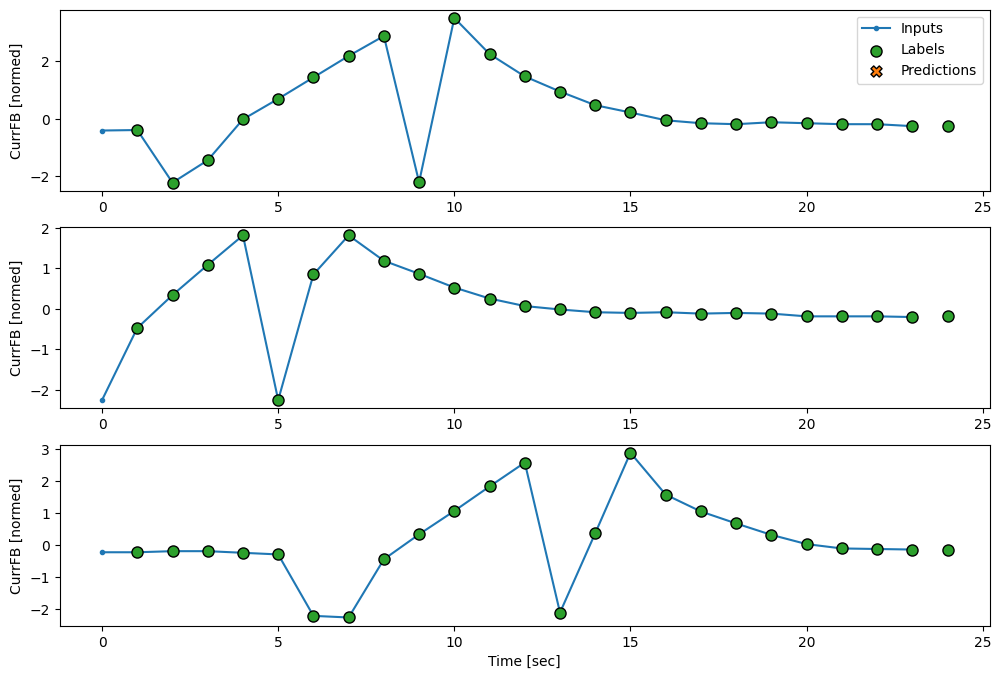

In [60]:
wide_window.plot(lstm_model)

# パフォーマンス
このデータセットでは、通常、各モデルは前のモデルよりわずかな改善が見られます。

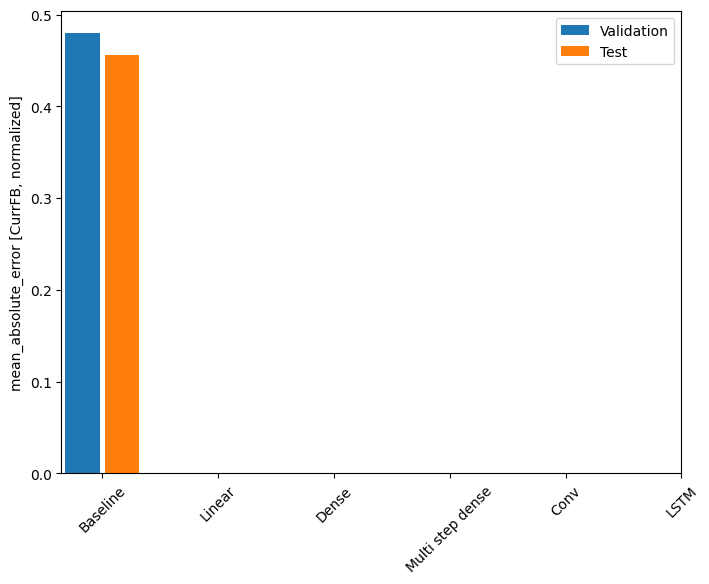

In [61]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [CurrFB, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [62]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.4559
Linear      : nan
Dense       : nan
Multi step dense: nan
Conv        : nan
LSTM        : nan


# 複数出力モデル
モデルはこれまで、単一時間ステップに対して単一出力特徴量 T (degC) をすべて予測しました。

これらのモデルはすべて、出力レイヤーのユニット数を変更し、labels（example_labels）のすべての特徴量を含めるようにトレーニングウィンドウを調整するだけで、複数の特徴量を予測するように変換することができます。

In [63]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 25)
Labels shape (batch, time, features): (32, 24, 25)


上記では、ラベルの features 軸に 1 ではなく、入力と同じ深度があることに注意してください。
# 基準
ここでは同じ基準モデルを使用できますが、今回は、特定の label_index を選択する代わりにすべての特徴量を繰り返します。

In [64]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [65]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

31/31 [==============================] - 0s 3ms/step - loss: nan - mean_absolute_error: nan


密度

In [66]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [67]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

32/32 [==============================] - 0s 3ms/step - loss: nan - mean_absolute_error: nan


RNN

In [68]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

31/31 [==============================] - 0s 6ms/step - loss: nan - mean_absolute_error: nan

CPU times: user 7.67 s, sys: 412 ms, total: 8.09 s
Wall time: 7.93 s


# 高度: 残留接続
上述の Baseline モデルは、時間ステップ間でシーケンスが大幅に変化しない事実を利用しました。このチュートリアルでトレーニングされたモデルはこれまで、ランダムに初期化されてから、出力が前の時間ステップからわずかに変化することを学習する必要がありました。

初期化に注意を払うことで、この問題を回避することはできますが、これをモデル構造に構築する方がより単純です。

時系列の分析では、次の値を予測する代わりに、次の時間ステップで値がどのように変化するかを予測するモデルを構築するのが一般的です。同様に、ディープラーニングの「残留ネットワーク」または「ResNet」は、各レイヤーがモデルの累積結果に追加されるアーキテクチャを指しています。

これが、変化は小さいものだという理解を活用する方法です。

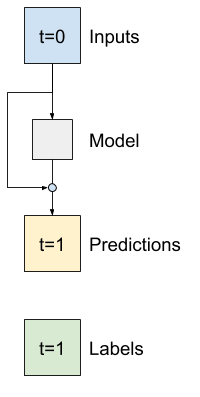

基本的に、これによってモデルは Baseline に一致するように初期化されます。このタスクでは、モデルのコンバージェンスを高速化することができ、わずかにパフォーマンスが向上されます。

このアプローチは、このチュートリアルで触れたあらゆるモデルと併用することができます。

ここでは、LSTM モデルに適用されています。最初の予測変化が小さく、残留接続より上回らないように、tf.initializers.zeros が使用されているところに注意してください。zeros は最後のレイヤーにだけ使用されているため、ここでは勾配の対称性が壊される懸念はありません。

In [69]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [70]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

31/31 [==============================] - 0s 6ms/step - loss: nan - mean_absolute_error: nan

CPU times: user 7.95 s, sys: 489 ms, total: 8.44 s
Wall time: 8.42 s


パフォーマンス
これらの複数出力モデルの全体的なパフォーマンスは、次のようになります。

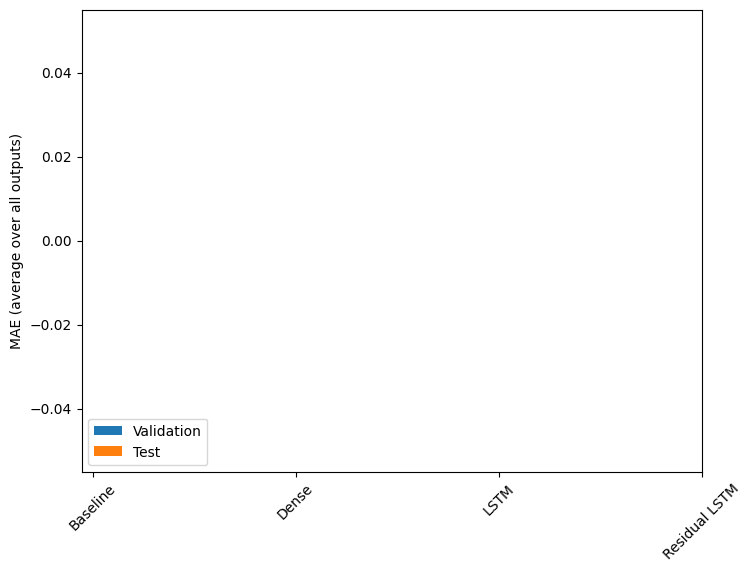

In [71]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [72]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : nan
Dense          : nan
LSTM           : nan
Residual LSTM  : nan


上記のパフォーマンスは、すべてのモデル出力の平均です。

# 複数ステップモデル
前のセクションの単一出力と複数出力はともに、1 時間先までの単一時間ステップ予測を行いました。

このセクションでは、これらのモデルを拡張し、複数時間ステップ予測を行います。

複数ステップ予測では、モデルは将来の値の範囲を予測できるように学習する必要があります。したがって、1 つの未来点を予測するだけの単一ステップモデルとは異なり、複数ステップモデルは、一連の未来の値を予測します。

これには、大まかに 2 つのアプローチがあります。

時系列全体を一度に予測するシングルショット予測
モデルは単一ステップ予測を行い、その出力が入力としてフィードされる、自動回帰予測
このセクションでは、すべてのモデルは、全出力時間ステップのすべての特徴量を予測します。

複数ステップモデルでは、トレーニングデータは時間ごとのサンプルで構成されますが、ここでは、過去 24 時間のデータがある場合に、モデルは 24 時間先を予測するように学習します。

次は、データセットからこれらのスライスを生成する Window オブジェクトです。

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

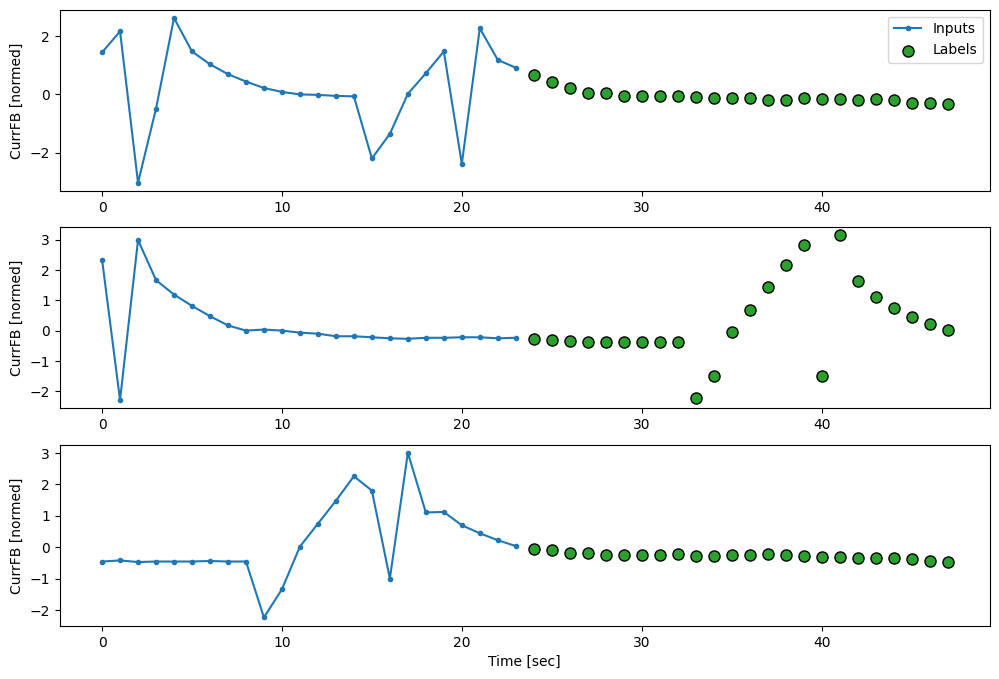

In [73]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

# 基準
このタスクの単純な基準は、最後の入力時間ステップを必要な出力時間ステップ数、繰り返すことです。

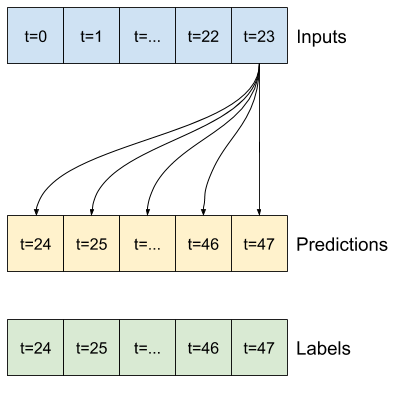

30/30 [==============================] - 0s 3ms/step - loss: nan - mean_absolute_error: nan


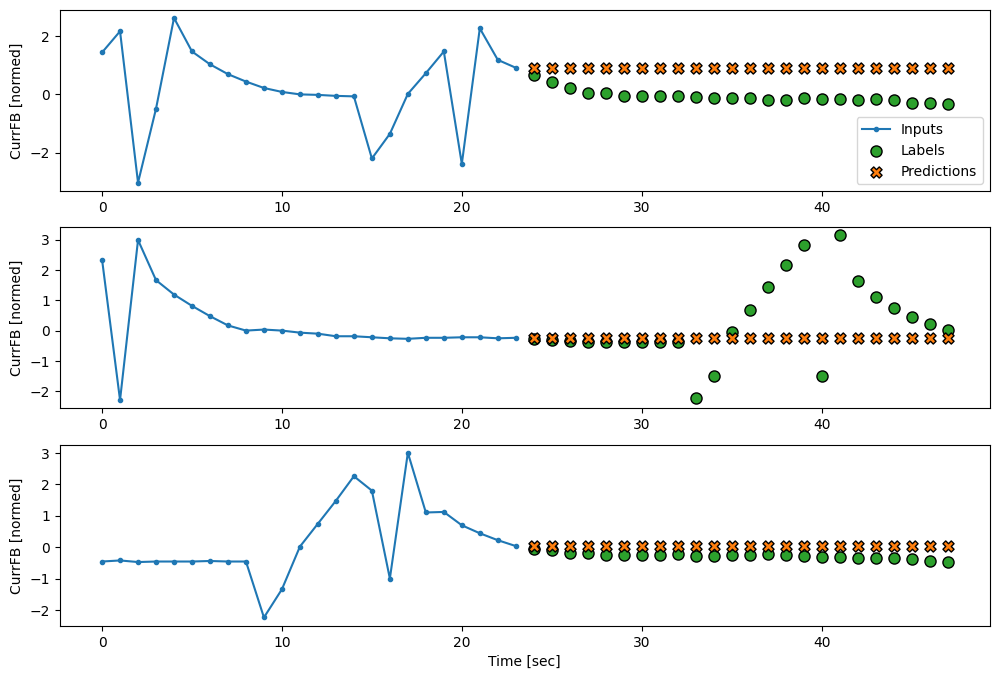

In [74]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

このタスクは、24 時間の履歴がある場合に 24 時間を予測するため、もう 1 つの単純なアプローチとして、翌日が同様であることを仮定し、前日を繰り返すことができます。

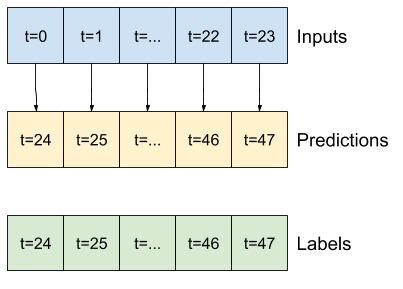

30/30 [==============================] - 0s 3ms/step - loss: nan - mean_absolute_error: nan


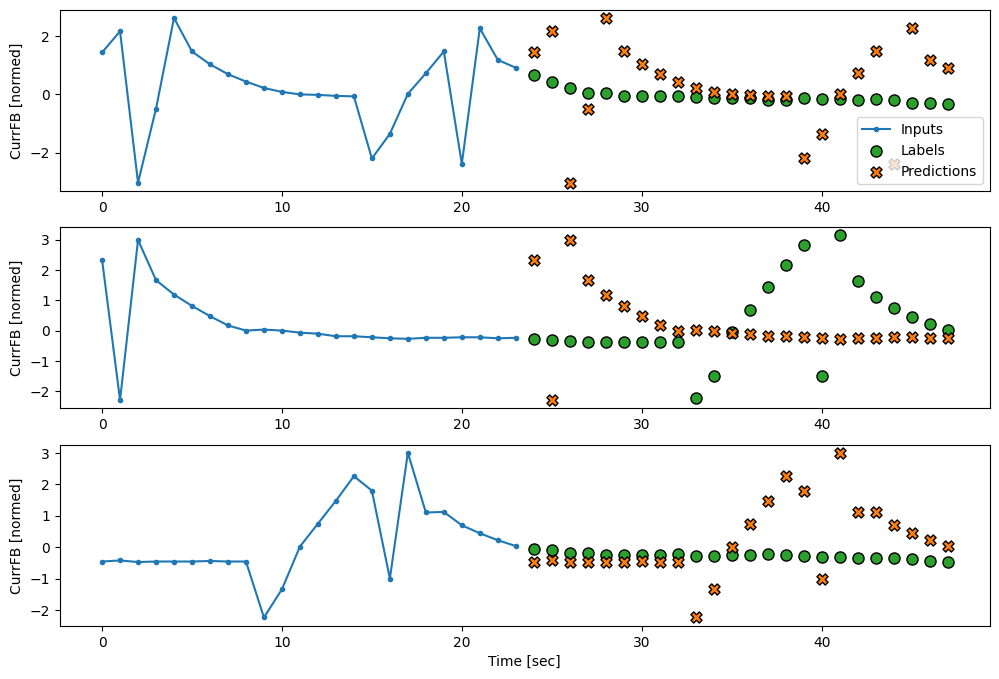

In [75]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

### シングルショットモデル
この問題の高レベルなアプローチには、モデルがシーケンス全体の予測を単一のステップで行う「シングルショット」モデルがあります。

これは、OUT_STEPS*features 出力ユニットを使って tf.keras.layers.Dense として効率的に実装できます。このモデルには、出力の形状を必要な (OUTPUT_STEPS, features) に設定し直すことだけが必要です。

### 線形
最後の時間ステップに基づく単純な線形モデルは、いずれの基準よりも優れていますが、パワーに劣ります。モデルは、線形投影の単一入力時間ステップから、OUTPUT_STEPS 時間ステップを予測する必要があります。おそらく主に時間帯と時期に基づいて、低次元スライスの行動のみをキャプチャできます。

最後のタイムステップからのすべてのタイムステップを予測します

30/30 [==============================] - 0s 4ms/step - loss: nan - mean_absolute_error: nan


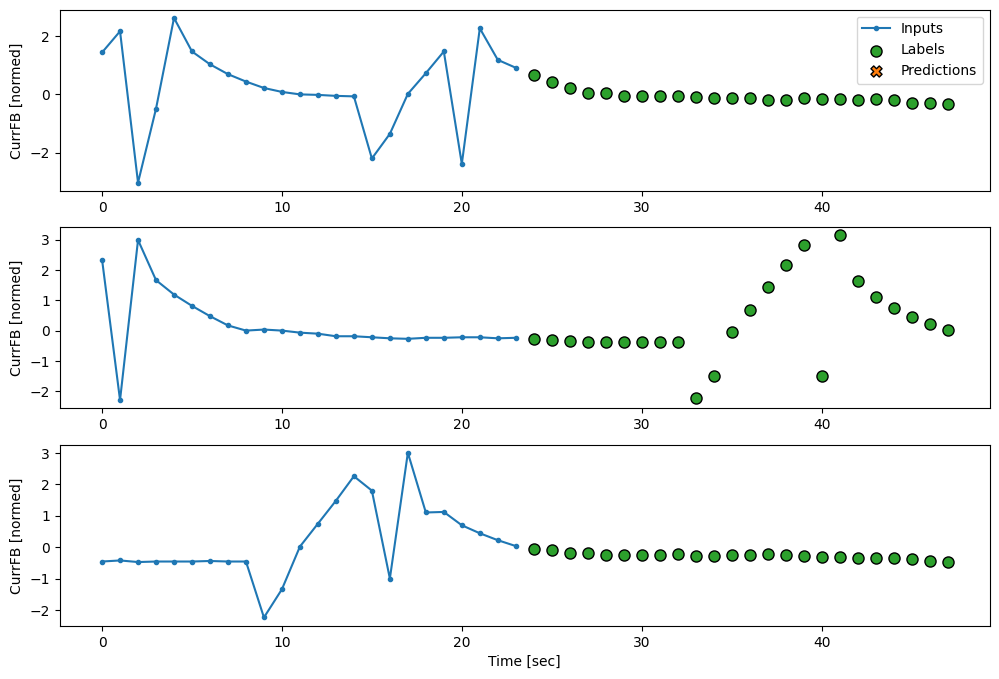

In [76]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

### 密度
入力と出力の間に tf.keras.layers.Dense を追加すると、線形モデルにパワーが追加されますが、依然として、単一入力時間ステップのみに基づいたままとなります。

30/30 [==============================] - 0s 4ms/step - loss: nan - mean_absolute_error: nan


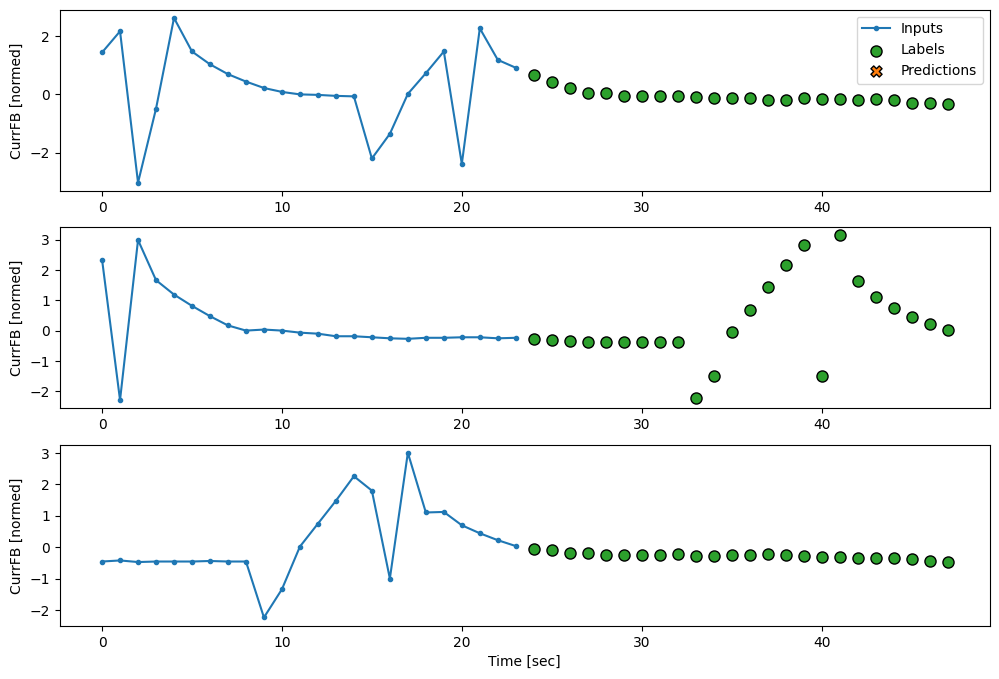

In [77]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

# CNN
畳み込みモデルは、固定幅の履歴に基づく予測を行います。このため、時間の経過とともに変化する様子を確認できるため、密度モデルよりも優れたパフォーマンスが得られる可能性があります。

30/30 [==============================] - 1s 13ms/step - loss: nan - mean_absolute_error: nan


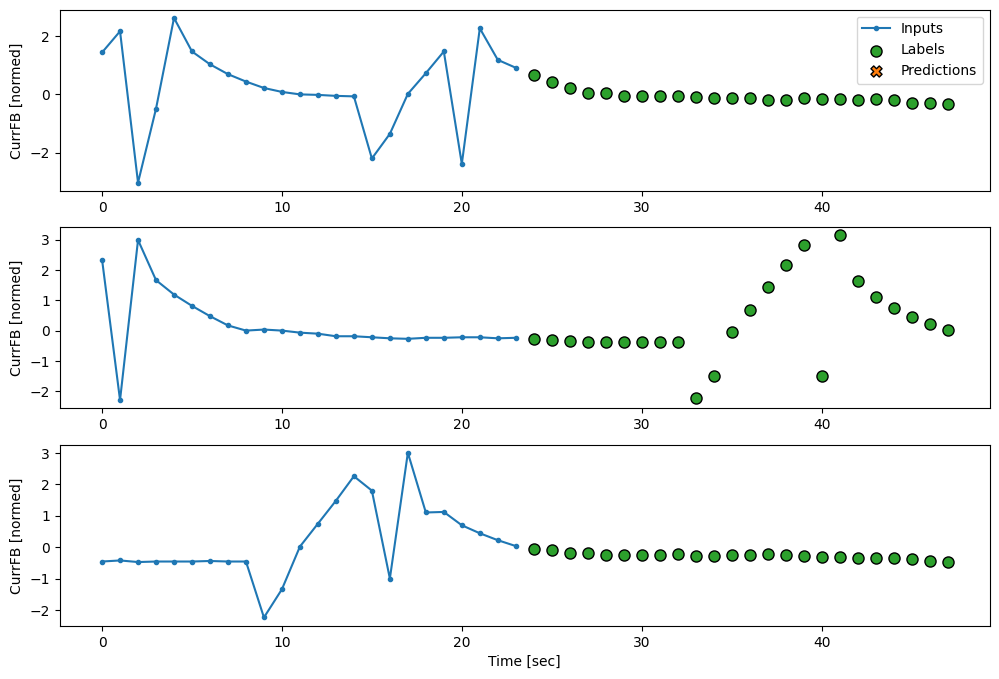

In [78]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

### RNN
回帰モデルは、入力の長い履歴がモデルが行おうとしている予測に関連している場合に、それを使用して学習できます。ここでは、内部状態を 24 時間累積した上で、次の 24 時間の単一の予測が行われます。

このシングルショット形式では、LSTM は、最後の時間ステップの出力のみを生成する必要があるため、tf.keras.layers.LSTM で return_sequences=False に設定します。

LSTM は入力ウィンドウで状態を累積し、24 時間先の単一の予測を行います

30/30 [==============================] - 0s 6ms/step - loss: nan - mean_absolute_error: nan


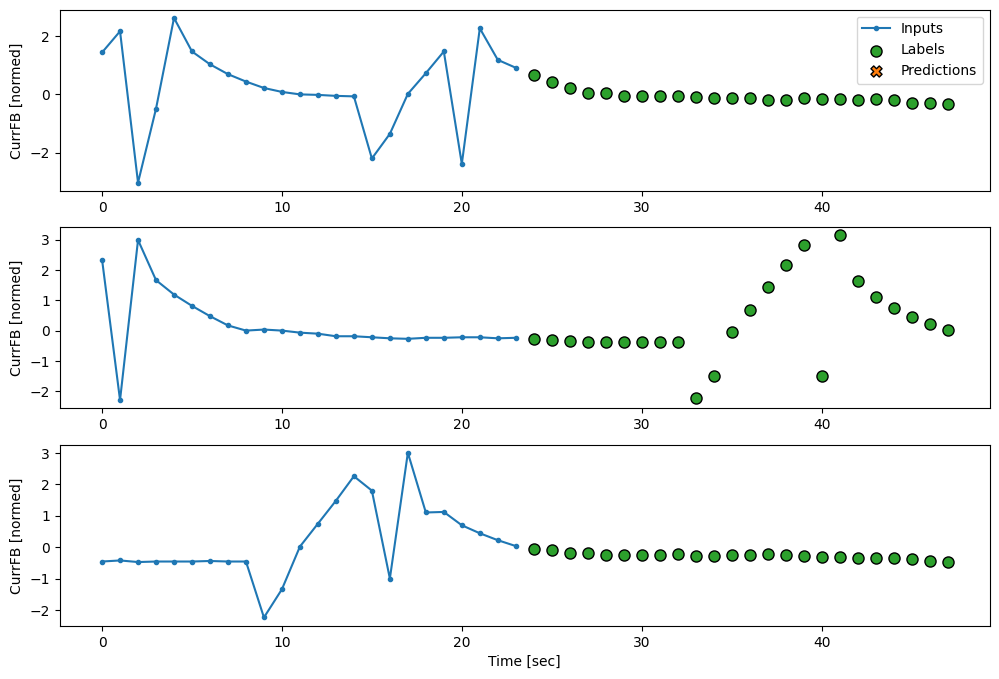

In [79]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

# 高度: 自動回帰モデル
上記のモデルはすべて、単一のステップで、出力シーケンス全体を予測します。

一部のケースでは、モデルがこの予測を個別の時間ステップに分解することが役立つ可能性があります。その上で、各モデルの出力を各ステップでそれ自体にフィードし、従来の「Generating Sequences With Recurrent Neural Networks」のように、前の予測で条件づけられた予測を立てることができます。

このスタイルのモデルには、長さの異なる出力を生成するようにセットアップできるという明確なメリットがあります。

このチュートリアルの前半でトレーニングされた単一ステップ複数出力モデルを使って、自動回帰フィードバックループで実行することもできますが、ここでは、それを行うように明示的にトレーニングされたモデルを構築することに焦点を当てることにします。

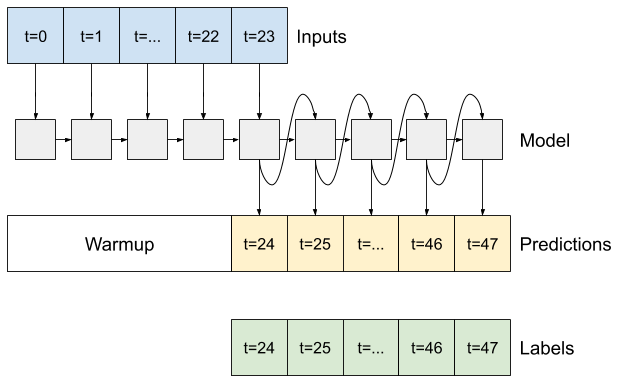

### RNN
このチュートリアルでは自動回帰 RNN モデルのみを構築しますが、このパターンは、単一時間ステップを出力するために設計されたモデルに適用することができます。

モデルには、前の単一ステップの LSTM モデルと同じ基本形式があります。LSTM レイヤーの出力をモデルの予測に変換する、tf.keras.layers.Dense が続く tf.keras.layers.LSTM レイヤーです。

tf.keras.layers.LSTM は、状態とシーケンス結果を管理するより高位の tf.keras.layers.RNN にラッピングされた tf.keras.layers.LSTMCell です（詳細は、Keras による回帰ニューラルネットワーク（RNN）ガイドをご覧ください。

この場合、モデルは、より低レベルの単一時間ステップインターフェースに直接 tf.keras.layers.LSTMCell を使用するように、各ステップの入力を手動で管理する必要があります。

In [80]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [81]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

このモデルが必要とする最初のメソッドは、入力に応じて内部状態を初期化する warmup メソッドです。トレーニングされると、この状態は入力履歴の関連する部分をキャプチャするようになります。これは、上記の単一ステップ LSTM モデルと同等です。

In [82]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

このメソッドは、単一の時間ステップ予測と LSTM の内部状態を返します。

In [83]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 25])

RNN の状態と初期の予測によって、各ステップの予測を入力としてフィードし直すモデルのイテレーションを続行できるようになりました。

出力予測を収集する最も単純なアプローチは、Python リストと、ループ後に tf.stack を使用する方法です。

注意: このような Python リストのスタックは、Eager execution、トレーニングの Model.compile(..., run_eagerly=True) の使用、または固定長出力によってのみ機能します。動的出力長については、Python リストの代わりに tf.TensorArray、Python range の代わりに tf.range を使用する必要があります。

In [84]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

サンプル入力にこのモデルをテスト実行します。

In [85]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 25)


次に、モデルをトレーニングします。

30/30 [==============================] - 0s 7ms/step - loss: nan - mean_absolute_error: nan


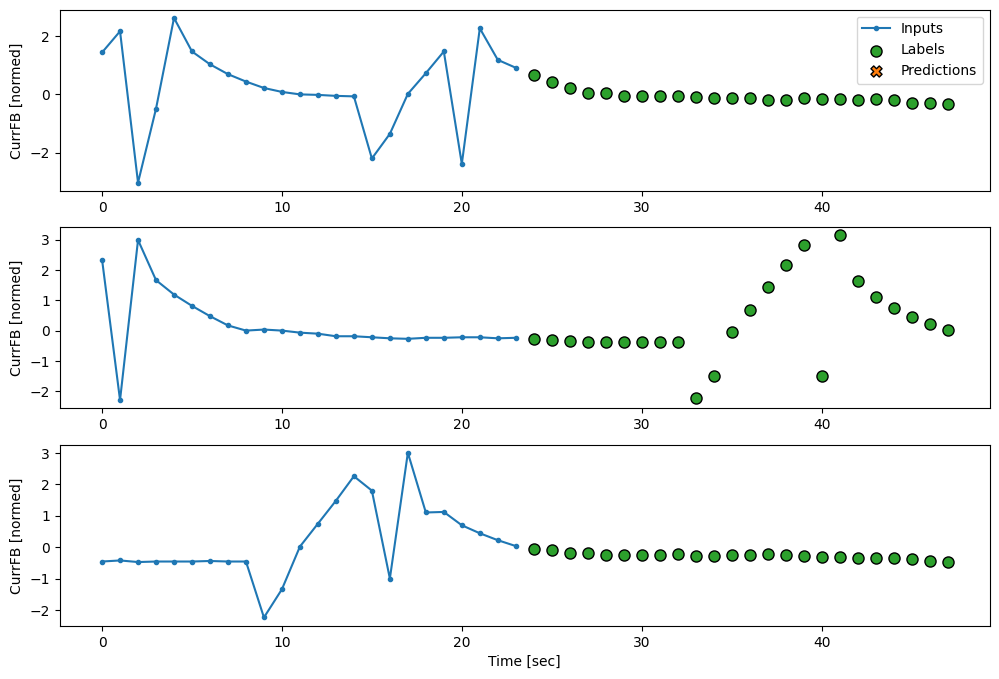

In [86]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

### パフォーマンス
この問題では、モデルの複雑さの関数として、戻り値が明確に小さくなっています。

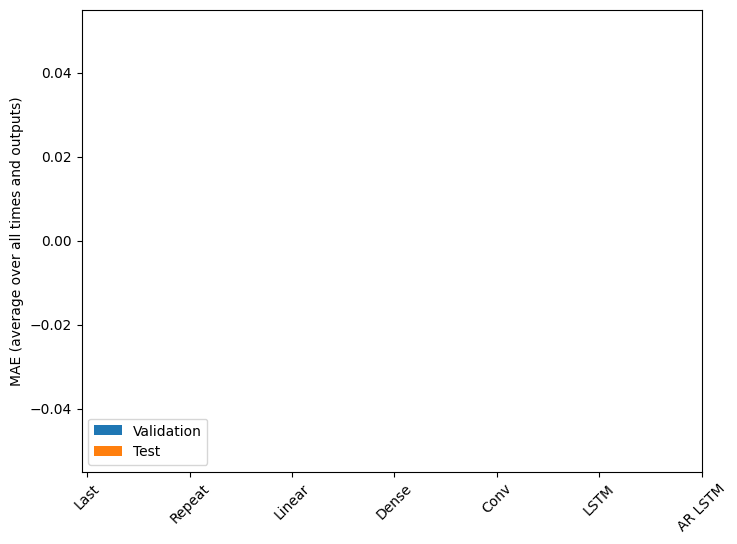

In [87]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

このチュートリアルの前半で説明した複数出力モデルのメトリックから、すべての出力特徴量全体で平均化されていることがわかります。これらのパフォーマンスは似ていますが、出力時間ステップ間でも平均化されています。

In [88]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : nan
Repeat  : nan
Linear  : nan
Dense   : nan
Conv    : nan
LSTM    : nan
AR LSTM : nan


密なモデルから畳み込みと回帰モデルに移行したことで得られたのは、あったとしてもわずか数パーセント程度で、自動回帰モデルのパフォーマンスは明らかに低いものでした。そのため、こういったより複雑なアプローチはこの問題に使用するほどの価値はありませんでしたが、試さなければ、このような結果も知るすべはありません。これらのモデルは、他の問題には役立つものかもしれません。

# 次のステップ
このチュートリアルでは、TensorFlow を使った時系列予測を簡単に紹介しました。

さらに学習するには、以下をご覧ください。

「Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow」（第 2 版）の第 15 章
「Deep Learning with Python」の第 6 章
「Udacity's intro to TensorFlow for deep learning」のレッスン 8、および実践ノートブック
また、TensorFlow では、古典的な時系列モデルを実装することもできます。このチュートリアルは、TensorFlow の組み込み機能に焦点が当てられています。